# Konvolucione neuronske mreze

## Arhitektura vizuelnog korteksa

Bioloski neuroni u vizuelnom korteksu reaguju na specificne obrasce u malim delovima vizuelnog polja koji se zovu prijemna polja; dok se vizuelni signal probija svojim putem kroz uzastopne module u mozgu, neuroni reaguju na sve slozenije obrasce u vecim prijemnim poljima.

## Konvolucioni slojevi

Neuroni u prvom konvolucionom sloju nisu povezani bas sa svakim pojedinacnim pikselom slike, nego samo s pikselima u svojim prijemnim poljima. Svaki neuron u drugom konvolucionom slojue je povezan s neuronima koji se nalaze unutar malog pravougaonika u prvom sloju.

Neuroni koji se nalazu u redu $i$, koloni $j$ datog sloja povezan je sa izlazima neurona u prethodnom sloju koji se nalaze u redovima od $i$ do $i + f_h - 1$, kolonama od $j$ do $j + f_w - 1$ gde su $f_h$ i $f_w$ visina i sirina prijemnog polja. Da bi jedan sloj imao istu visinu i sirinu kao prethodni sloj uobicajeno je da se oko izlaza dodaju nule (zero padding).

Rastojanje od jednog prijemnog polja do sledeceg zove se korak (stride). Od $i * s_h$ do $i * s_h + f_h - 1$ i od $j * s_w$ do $j * s_w + f_w - 1$, gde su $s_h$ i $s_w$ visina i sirina koraka.

## Filtri

Tezine jednog neurona mogu se predstaviti u obliku male slike velicine prijemnog polja. 

In [1]:
import tensorflow as tf
from tensorflow import keras

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

import numpy as np

In [3]:
def plot_image(image):
  plt.imshow(image, cmap='gray', interpolation='nearest')
  plt.axis('off')

def plot_color_image(image):
  plt.imshow(image, interpolation='nearest')
  plt.axis('off')

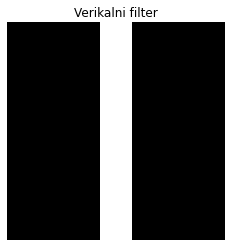

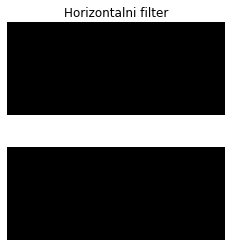

2022-03-23 09:59:50.793606: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-23 09:59:51.001810: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-23 09:59:51.002053: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-23 09:59:51.002623: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

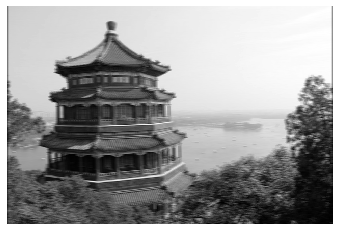

In [4]:
from sklearn.datasets import load_sample_image

china = load_sample_image('china.jpg') / 255.0
flower = load_sample_image('flower.jpg') / 255.0
images = np.array([china, flower])
batch_size, height, width, channels = images.shape

filters = np.zeros(shape=(7,7, channels, 2), dtype=np.float64)
filters[:, 3, :, 0] = 1
filters[3, :, :, 1] = 1



plot_image(filters[:, :, :, 0])
plt.title('Verikalni filter')
plt.show()
plot_image(filters[:, :, :, 1])
plt.title('Horizontalni filter')
plt.show()

outputs = tf.nn.conv2d(images, filters, strides=1, padding='SAME')
plot_image(outputs[0, :, :, 1])
plt.show()

In [4]:
def crop(images):
  return images[150:220, 130:250]

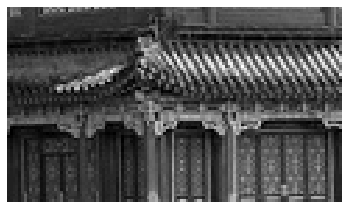

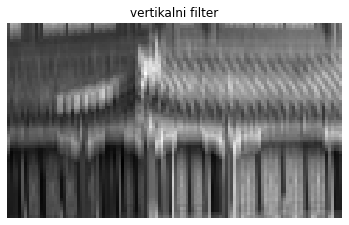

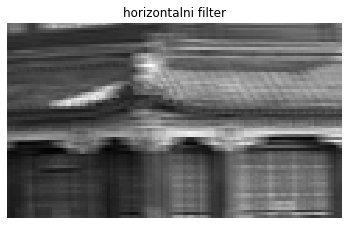

In [47]:
plot_image(crop(images[0, :, :, 0]))
plt.show()

for feature_map_index, name in enumerate(['vertikalni filter', 'horizontalni filter']):
  plot_image(crop(outputs[0, :, :, feature_map_index]))
  plt.title(name)
  plt.show()

Jedan sloj ciji svi neuroni koriste isti filtar formira mapu osobina u kojoj su istaknuti delovi slike koji najvise aktiviraju taj filtar.

### Slaganje vise mapa osobina

Jedan sloj primenjuje na svoje ulaze vise podesicih filtara istovremeno sto mu omogucava da prepoznaje vise osobina bilo gde na svojim ulazima.

### Implementacija u tensorflowu

In [57]:
np.random.seed(42)
tf.random.set_seed(42)

conv = keras.layers.Conv2D(filters=2, kernel_size=5, strides=1,
                           padding="SAME", activation="relu", input_shape=outputs.shape)

In [58]:
conv_outputs = conv(images)
conv_outputs.shape 

TensorShape([2, 427, 640, 2])

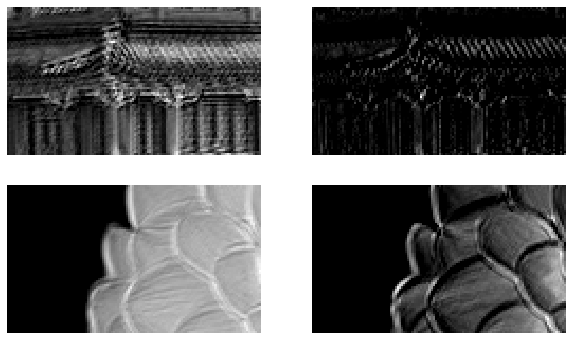

In [59]:
plt.figure(figsize=(10,6))
for image_index in (0, 1):
    for feature_map_index in (0, 1):
        plt.subplot(2, 2, image_index * 2 + feature_map_index + 1)
        plot_image(crop(conv_outputs[image_index, :, :, feature_map_index]))
plt.show()

## Redukcioni slojevi

Cilj redukcionih slojeva je da sazmu ulaznu sliku da bi smnjili slozenost proracuna, potrosnju memorije i broj parametara (cime umanjuju rizik prekomernog uklpanja modela).

Svaki neuron u redukcionom sloje je povezan sa izlazima ogranicenog broja neurona u prethodnom sloju, koji se nalaze unutra malog pravougaonika prijemnog polja. Moramo deifnisati njegovu velicinu korak i tip dopunjavanja isto kao i ranije. Medjutim redukcioni sloj nema tezine sve sto on radi je agregiranje svojih ulaza pomocu neke agregatne funkcije kao sto je izracunjavanje maksimuma ili srednje vrednosti.

Redukcioni sloj uvodi i odredjeni nivo neosetljivosti (invariance) na male otklone.

### Implementacija u TF

In [5]:
max_pool = keras.layers.MaxPool2D(pool_size=2)

In [6]:
cropped_images = np.array([crop(image) for image in images], dtype=np.float32)
output = max_pool(cropped_images)

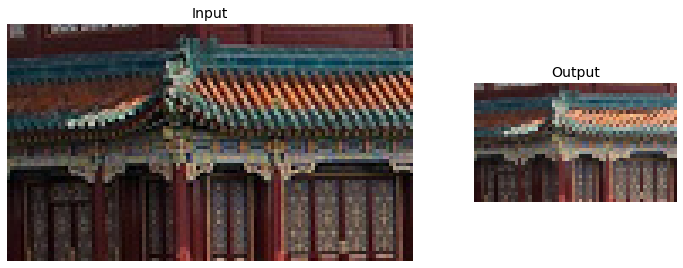

In [7]:
fig = plt.figure(figsize=(12, 8))
gs = mpl.gridspec.GridSpec(nrows=1, ncols=2, width_ratios=[2, 1])

ax1 = fig.add_subplot(gs[0, 0])
ax1.set_title("Input", fontsize=14)
ax1.imshow(cropped_images[0]) 
ax1.axis("off")
ax2 = fig.add_subplot(gs[0, 1])
ax2.set_title("Output", fontsize=14)
ax2.imshow(output[0])  
ax2.axis("off")
plt.show()

Redukcioni sloj na maksimum je nesto bolji jer umesto redukcionog sloja na prosek on zadrzava samo najjace osobine i odbacuje sve one koje ne doprinose nicemu, pa zato naredni slojevi dobijaju cistiji signal za obradu.

## Arhitekture CNN

Tipicna arhitektura CNN se sastoji od nekoliko konvolucionig slojeva, zatim jedan redukcioni sloj, zatim jos nekoliko konvolucionih slojeva, pa jos jedan redukcioni sloj itd. Na vrh celog tog sklopa dodaje se obicna neuronska mreza koja se sastoji od nekoliko potpuno povezanih slojeva i zavrsnog izlaznog sloja.

In [10]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

X_mean = X_train.mean(axis=0, keepdims=True)
X_std = X_train.std(axis=0, keepdims=True) + 1e-7
X_train = (X_train - X_mean) / X_std
X_valid = (X_valid - X_mean) / X_std
X_test = (X_test - X_mean) / X_std

X_train = X_train[..., np.newaxis]
X_valid = X_valid[..., np.newaxis]
X_test = X_test[..., np.newaxis]

In [8]:
from functools import partial

DefaultConv2D = partial(keras.layers.Conv2D,
                        kernel_size=3, activation='relu', padding='same')

model = keras.models.Sequential([
  DefaultConv2D(filters=64, kernel_size=7, input_shape=[28, 28, 1]),
  keras.layers.MaxPooling2D(pool_size=2),
  DefaultConv2D(filters=128),
  DefaultConv2D(filters=128),
  keras.layers.MaxPooling2D(pool_size=2),
  DefaultConv2D(filters=256),
  DefaultConv2D(filters=256),
  keras.layers.MaxPooling2D(pool_size=2),
  keras.layers.Flatten(),
  keras.layers.Dense(128, activation='relu'),
  keras.layers.Dropout(0.5),
  keras.layers.Dense(64, activation='relu'),
  keras.layers.Dropout(0.5),
  keras.layers.Dense(10, activation='softmax')
])

In [11]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid))
score = model.evaluate(X_test, y_test)
X_new = X_test[:10] # pretend we have new images
y_pred = model.predict(X_new)

2022-03-13 10:54:43.558101: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 172480000 exceeds 10% of free system memory.
2022-03-13 10:54:43.706691: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 172480000 exceeds 10% of free system memory.


Epoch 1/10
1719/1719 [==============================] - ETA: 0s - loss: 0.7028 - accuracy: 0.7519

2022-03-13 10:55:05.670852: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 15680000 exceeds 10% of free system memory.
2022-03-13 10:55:05.696792: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 15680000 exceeds 10% of free system memory.


1719/1719 [==============================] - 23s 12ms/step - loss: 0.7028 - accuracy: 0.7519 - val_loss: 0.3599 - val_accuracy: 0.8688
Epoch 2/10
1719/1719 [==============================] - 20s 11ms/step - loss: 0.4236 - accuracy: 0.8578 - val_loss: 0.3493 - val_accuracy: 0.8726
Epoch 3/10
1719/1719 [==============================] - 21s 12ms/step - loss: 0.3628 - accuracy: 0.8778 - val_loss: 0.3425 - val_accuracy: 0.8850
Epoch 4/10
1719/1719 [==============================] - 21s 12ms/step - loss: 0.3296 - accuracy: 0.8897 - val_loss: 0.3083 - val_accuracy: 0.8888
Epoch 5/10
1719/1719 [==============================] - 21s 12ms/step - loss: 0.3036 - accuracy: 0.8965 - val_loss: 0.2773 - val_accuracy: 0.8968
Epoch 6/10
1719/1719 [==============================] - 20s 12ms/step - loss: 0.2865 - accuracy: 0.9026 - val_loss: 0.3036 - val_accuracy: 0.8938
Epoch 7/10
1719/1719 [==============================] - 20s 11ms/step - loss: 0.2782 - accuracy: 0.9061 - val_loss: 0.2802 - val_accura

2022-03-13 10:58:09.264086: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 31360000 exceeds 10% of free system memory.


313/313 [==============================] - 1s 5ms/step - loss: 0.2821 - accuracy: 0.9024


### LeNet-5

| Sloj | Tip | Broj mapa | Velicina | Velicina jezgra | Korak | Aktivacija |
| --- | --- | --- | ---| --- | --- | --- |
| Izlazni | Potpuno povezan | - | 10 | - | - | RBF |
| F6 | Potpuno povezan | - | 84 | - | - | tanh |
| C5 | Konvolucioni | 120 | 1 x 1 | 5 x 5 | 1 | tanh | 
| S4 | Redukcioni na prosek | 16 | 5 x 5 | 2 x 2 | 2 | tanh |
| C3 | Konvolucioni | 16 | 10 x 10 | 5 x 5 | 1 | tanh |
| S2 | Redukcioni na prosek | 6 | 14 x 14 | 2 x 2 | 2 | tanh |
| C1 | Konvolucioni | 6 | 28 x 28 | 5 x 5 | 1 | tanh |
| Ulazni | Ulazni | 1 | 32 x 32 | - | - | - |

* Redukcioni sloj na prosek je drugaciji: svaki neuron izracunava srednju vrednost svojih ulaza, zatim rezultat mnozi koeficijentom koji se podesava tokom obuke (jedan po mapi) i dodaje takodje podesiv clan pomeranja, a na kraju primenjuje aktivirajucu funkciju.
* Vecina neurona u C3 mapama je povezana s neuronima u samo tri ili cetiri S2 mape (umesto sa svim S2 mapama).
* Izlazni sloj je poseban jer umesto unakrsne entropije izracunava matricni umnozak svojih ulaza vektorom tezina, svaki neuron izracunava kvadrat Euklidovog rastojanja izmedju vektora svojih ulaznih vrednosti i svog vektora tezina.

### AlexNet

Slicna je arhitekturi LeNet-5 samo je znatno opseznija i dublja, a bila je prva u kojoj su konvolucioni slojevi postavljeni neposredno jedan iznad drugog umesto da iznad svakog konvolucionog sloja bude jedan redukcioni sloj.

| Sloj | Tip | Broj mapa | Velicina | Velicina jezgra | Korak | Padding | Aktivacija |
| --- | --- | --- | --- | --- | --- | --- | --- |
| Izlazni | Potpuno povezan | - | 1000 | - | - | - | Softmax |
| F10 | Potpuno povezan | - | 4096 | - | - | - | ReLU |
| F9 | Potpuno povezan | - | 4096 | 6 x 6 | 1 | ReLU | 
| S8 | Redukcioni na maksimum | 256 | 6 x 6 | 3 x 3 | 2 | valid | - |
| C7 | Konvolucioni | 256 | 13 x 13 | 3 x 3 | 1 | same | ReLU |
| C6 | Konvolucioni | 384 | 13 x 13 | 3 x 3 | 1 | same | ReLU |
| C5 | Konvolucioni | 384 | 13 x 13 | 3 x 3 | 1 | same | ReLU |
| S4 | Redukcioni na maksimum | 256 | 10 x 10 | 5 x 5 | 1 | valid | - |
| C3 | Konvolucioni | 256 | 27 x 27 | 5 x 5 | 1 | same | ReLU |
| S2 | Redukcioni na maksimum | 96 | 27 x 27 | 3 x 3 | 2 | valid | - |
| C1 | Konvolucioni | 96 | 55 x 55 | 11 x 11 | 4 | valid | ReLU |
| Ulazni | Ulazni | 3(RGB) | 227 x 227 | - | - | - | - |

AlexNet koristi korak normalizacije neposredno iza koraka ReLU u slojevima C1 i C3 koji se zove normalizacija lokalnog odziva: najjace probudjeni neuroni iskljucuju druge neurone koji se nalaze na istim polozajima u drugim susednim mapama osobina. To podstice razlicite mape osovina da se specijalizuju, tako sto ih udaljava jednu od druge i primorava da istrazuju siri opseg osobina.

### GoogLeNet

GoogLeNet koristi podmreze nazvane polazni moduli (inception modules) koji omogucavaju da parametre koristi na znatno efikasniji nacin nego prethodne arhitekture: GoogLeNet zapravo ima 10 puta manje parametara nego AlexNet (6m vs 60m).

![](../img/2.5./inception_module.png)

Ulazni signal se prvo kopira i prosledjuje na 4 razlicita sloja. Druga grupa slojeva ima razlicite velicine jezgra sto im omogucava da prepoznaju obrasce drugih razmera. Svi slojevi koriste korak nadovezivanja 1 i dopunjavanje 'same'. To omogucava da se svi izlazni rezultati nadovezu duz dimenzije dubine u sloju za dubinsko nadovezivanje.

Slojevi sa jezgrima 1 x 1 nisu u stanju da prepoznaju prostorne obrasce zato sto gledaju jedan po jedan piksel ali imaju druge namene:
* Mogu da prepoznaju obrasce duz dubine
* Podeseni su tako da svojim izlazima prosledjuju manji broj mapa osobina nego sto ig primaju na ulazima pa tako sluze kao uska grla sto znaci da oni smanjuju dimenzionalnost.
* Svaki par konvolucionih slojeva ([1 x 1, 3 x 3] i [1 x 1, 5 x 5]) deluj kao jedan mocan konvolucioni sloj, koji je u stanju da prepoznaje slozenije obrasce. Umesto da preko sloja prevuce samo jedan linearni klasifikator, taj par konvolucionih slojeva prevlaci preko slike dvoslojnu neuronsku mrezu.

![](../img/2.5./googlenet_architecture.png)

In [8]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, Dropout
from keras.layers.merge import concatenate

In [9]:
def Inception_block(input_layer, f1, f2_conv1, f2_conv3, f3_conv1, f3_conv5, f4):
  
  path1 = Conv2D(filters=f1, kernel_size = (1, 1), padding= 'same', activation='relu')(input_layer)
  
  path2 = Conv2D(filters=f2_conv1, kernel_size = (1, 1), padding= 'same', activation='relu')(input_layer)
  path2 = Conv2D(filters=f2_conv3, kernel_size = (3, 3), padding= 'same', activation='relu')(path2)
  
  path3 = Conv2D(filters=f3_conv1, kernel_size = (1, 1), padding= 'same', activation='relu')(input_layer)
  path3 = Conv2D(filters=f3_conv5, kernel_size = (5, 5), padding= 'same', activation='relu')(path3)
  
  path4 = MaxPooling2D(pool_size=(3, 3), strides = 1, padding='same')(input_layer)
  path4 = Conv2D(filters=f4, kernel_size = (1, 1), padding= 'same', activation='relu')(path4)
  
  output_layer = concatenate([path1, path2, path3, path4])
  
  return output_layer

In [10]:
def GoogLeNet():
  
  input_layer = Input(shape = (224, 224, 3))
  
  X = Conv2D(filters = 64, kernel_size = (7, 7), padding='same', strides= 2, activation='relu')(input_layer)
  
  X = MaxPooling2D(pool_size=(3, 3), strides = 2, padding='same')(X)
  
  ## optimizacija lokalnog odziva
  
  X = Conv2D(filters = 64, kernel_size = (1, 1), padding='same', strides= 1, activation='relu')(X)
  X = Conv2D(filters = 192, kernel_size = (3, 3), padding='same', strides= 1, activation='relu')(X)
  
  X = MaxPooling2D(pool_size=(3, 3), strides = 2, padding='same')(X)
  
  X = Inception_block(X, f1 = 64, f2_conv1 = 128, f2_conv3= 32, f3_conv1= 32, f3_conv5  = 96, f4 = 16)
  X = Inception_block(X, f1 = 128, f2_conv1 = 192, f2_conv3= 96, f3_conv1= 64, f3_conv5  = 128, f4 = 32)
  
  X = MaxPooling2D(pool_size=(3, 3), strides = 2, padding='same')(X)
  
  X = Inception_block(X, f1 = 192, f2_conv1 = 208, f2_conv3= 48, f3_conv1= 64, f3_conv5  = 96, f4 = 32)
  X = Inception_block(X, f1 = 160, f2_conv1 = 224, f2_conv3= 64, f3_conv1= 64, f3_conv5  = 112, f4 = 24)
  X = Inception_block(X, f1 = 128, f2_conv1 = 256, f2_conv3= 64, f3_conv1= 64, f3_conv5  = 128, f4 = 24)
  X = Inception_block(X, f1 = 112, f2_conv1 = 288, f2_conv3= 64, f3_conv1= 64, f3_conv5  = 144, f4 = 32)
  X = Inception_block(X, f1 = 256, f2_conv1 = 320, f2_conv3= 128, f3_conv1= 128, f3_conv5  = 160, f4 = 32)

  X = MaxPooling2D(pool_size=(3, 3), strides = 2, padding='same')(X)

  X = Inception_block(X, f1 = 256, f2_conv1 = 320, f2_conv3= 128, f3_conv1= 128, f3_conv5  = 160, f4 = 32)
  X = Inception_block(X, f1 = 384, f2_conv1 = 384, f2_conv3= 128, f3_conv1= 128, f3_conv5  = 192, f4 = 48)

  X = GlobalAveragePooling2D(name='GAPL')(X)
  
  X = Dropout(rate = 0.4)(X)
  
  X = Dense(1000, activation='softmax')(X)
  
  model = Model(input_layer, X, name='GoogLeNet')
  
  return model
  

In [12]:
GoogLeNet().summary()

Model: "GoogLeNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_66 (Conv2D)             (None, 112, 112, 64  9472        ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 max_pooling2d_16 (MaxPooling2D  (None, 56, 56, 64)  0           ['conv2d_66[0][0]']              
 )                                                                                        

### ResNet

Kljuc za obuku jako duboke neuronske mreze je upotreba zaobilaznih veza: signal koji se dovodi na ulaz jednog sloja dodaje se i na izlaz sloja koji se nalazi malo vise na sveznju slojeva.

![Rezidualna jedinica](../img/2.5./residual_unit.png)

Ako se doda veci broj zaobilaznih veza mreza moze poceti da napreduje uprkos tome sto nekoliko slojeva jos nije ni pocelo da uci.

<img src="../img/2.5./RI_learning.jpg" width="600" height="400">

#### Arhitektura ResNet-50

![](../img/2.5./resnet-50.png)

Broj mapa osobina se udvostrucuje svakih nekoliko rezidualnih jedinica a istovremeno se njihove visine i sirine prepolovljuju. Kada se to dogodi ulazne vrednosti se ne mogu direktno dodati vrednostima na izlazima rezidualne jedinice zato sto nemaju isti oblik. Resenje tog problema je da se ulazne vrednosti prosledjuju kroz jedan konvolucioni sloj 1x1 s korako 2 i odgovarajucim brojem mapa osobina.

### Xception

Xception polazne module arhitekture Inception zamenjuje specijalnom vrstom sloja nazvanim konvolucioni sloj razdvojiv po dubini.<br>
Depthwise separable convolution layer se razlikuje od obicnog konvolucionog sloja po tome sto umesto da pokusava da prepozna prostorne i dubinske obrasce istovremeno, u DPC slojevima se taj proces razdvaja na dva. Prvi deo primenjuje jedan prostorni filter na svaku ulaznu mapu osobina, a zatim drugi deo trazi iskljucivno kombinovance obrasce iz vise kanala.

<figure style="display: inline-block">
  <img src="../img/2.5./normal_conv.png" width="800" height="400">
  <figcaption style="text-align: center">Normalna konvolucija</figcaption>
</figure>
<figure style="display: inline-block">
  <img src="../img/2.5./depthwise_conv.png" width="800" height="400">
  <figcaption style="text-align: center">Prvi deo - depthwise konvolucija</figcaption>
</figure>
<figure style="display: inline-block">
  <img src="../img/2.5./pointwise_conv.png" width="800" height="400">
  <figcaption style="text-align: center">Drugi deo - pointwise konvolucija</figcaption>
</figure>

Ova metoda smanjuje broj kalkulacija drasticno. Sa 256 5x5x3 jezgra koja se pomeraju 8x8 puta to je 256x3x5x5x8x8 = 1,228,000 kalkulacija.<br>
Koristeci DSC, u prvom delu imamo 3 5x5x1 jezgra koja se pomeraju 8x8 puta, to je 3x5x5x8x8=4,800 kalkulacija, u drugom delu imamo 256 1x1x3 jezgra koja se pomeraju 8x8 puta, to je 256x3x8x8 = 49,152 kalkulacija. Sve zajedno to je 53,952 kalkulacija, dosta manje od 1,228,000.

<figure style="display: inline-block">
  <img src="../img/2.5./xception.png" width="800" height="600">
  <figcaption style="text-align: center">Cela arhitektura Xception</figcaption>
</figure>

### SENet

SENet (Squeeze-and-Excitation Network - mreza sa prigusivanjem i pojacavanjem) predstavlja arhitekturu koja prosiruje postojecec arhitekture kao sto su mreze s polaznim modulima ili ResNet mreze i poboljsava njihove performanse. Te prosirene verzije mreza zovu se SE-Inception i SE-ResNet. Poboljsanje potice od cinjenice da svakoj jedniici u izvornoj arhitekturi dodaje mala neuronska mreza koja se zove SE blok.

<figure style="display: inline-block">
  <img src="../img/2.5./SENet.png" width="800" height="400">
  <figcaption style="text-align: center">SE-Inception modul i SE-ResNet modul</figcaption>
</figure>

SE blok analizira izlaz jedinice kojoj je pridruzen, pri cemu se usredsredjuje samo na dimenziju dubine i otkriva koje su osobine obicno najaktivnije zajedno. Zatim na osnovu te informacije kalibrise mapu osobina.

### MobileNet v1

MobileNet arhitektura je jako slicna Xception arhitekturi po tome sto koristi Depthwise Separable Convolution slojeve. Razlika izmedju ove dve arhitekture je u tome sto MobileNet izmedju depthwise i pointwise konvolucije koristi Batch Normalization sloj i ReLU6 sloj.

<figure style="display: inline-block">
  <img src="../img/2.5./MobileNet1-block.png" width="300" height="400">
  <figcaption style="text-align: center">DSC sloj</figcaption>
</figure>

ReLU6 je varijacija ReLU funkcije koja ima oblik $y = min(max(0,x), 6)$. Utvrdjeno je da je ova funkcija bolja u radu kada se koristi niska preciznost.

<figure style="display: inline-block">
  <img src="../img/2.5./ReLU6.png" width="600" height="300">
  <figcaption style="text-align: center">ReLU6</figcaption>
</figure>

Ova arhitektura ne koristi Pooling slojeve vec neki DSC slojevi imaju stride=2 i tako smanjuju dimenziju slike, kada se to desi pointwise deo udvostrucuje broj mapa.

<figure style="display: inline-block">
  <img src="../img/2.5./MobileNet1-arch.png" width="400" height="450">
  <figcaption style="text-align: center">Kompletna arhitektura</figcaption>
</figure>

### MobileNet v2

MobileNet v2 idalje koristi dw layere ali njegov blok sada izgleda ovako

<figure style="display: inline-block">
  <img src="../img/2.5./MobileNetv2-block.png" width="300" height="400">
  <figcaption style="text-align: center">MBConv</figcaption>
</figure>

Poslednja dva sloja su deo DW sloja, ali 1x1 konvolucija ima drugaciju primenu. Umesto da dubinu ostavi istu ili duplira ovaj sloj smanjuje dubinu, <i>projektuje</i> tensor sa vise dimenzija u tensor sa manje dimenzija. Ovaj sloj se takodje naziva sloj uskog grla (bottleneck) jer smanjuje broj podataka koji putuju kroz mrezu.

Prvi sloj je drugaciji i on predstavlja expansion layer, sloj koji tensor prebacuje u vise dimenzija, suprotno od projection layera. 

Za koliko se tacno podaci sire/smanjuju odredjeno je hiperparametrom <i>expansion factor</i> koji se postavlja od 5 do 10 i tipicna vrednost mu je 6.

<figure style="display: inline-block">
  <img src="../img/2.5./ExpandProject.png" width="800" height="200">
  <figcaption style="text-align: center"></figcaption>
</figure>

Ova dva sloja smanjuju broj komputacija u neuronskoj mrezi. Kljuc eskpanzije i projekcije je da su to konvolucioni slojevi sa parametrima koje mreza moze da nauci, tj. mreza moze da nauci kako da najbolje kompresuje i unkompresuje tensore.

<figure style="display: inline-block">
  <img src="../img/2.5./Compression.png" width="800" height="150">
  <figcaption style="text-align: center"></figcaption>
</figure>

### EfficientNet

EfficientNet koristi tehniku slozenih koeficijenata (compound coefficients) da skalira modele lako i efikasno. Umesto da nasumicno skalira sirinu, dubinu i rezoluciju, slozeno skaliranje skalira sve dimenzije zajedno sa setom koeficijenata za skaliranje.

<figure style="display: inline-block">
  <img src="../img/2.5./CompoundScaling.png" width="700" height="350">
  <figcaption style="text-align: center"></figcaption>
</figure>

Matematicki imamo 3 parametra: <br>
Dubinu $d = \alpha^\theta$, Sirinu $w = \beta^\theta$, Rezoluciju $r = \gamma^\theta$<br>
tako da je $\alpha * \beta^2 * \theta^2 \approx 2$

Vrednosti $\alpha, \beta, \gamma$ su pronadjene koriscenjem grid search algoritma. $\Theta$ podesava povecanje u resursima koji su dati mrezi. Ovaj parametar definise korisnik. Skaliranje mreze koristeci gore definisanu jednacinu povecava FLOPS za $(\alpha * \beta^2 * \theta^2) ^ \theta$. Zato sto je $\alpha * \beta^2 * \theta^2$ priblizno 2, za svako novo $\theta$, FLOPS se povecava za $2^\theta$

Kada je $\theta$ podeseno na 1 koriscenjem grid search algoritma dobija vrednosti za parametre $\alpha$ = 1.2, $\beta = 1.1$, $\theta = 1.15$. To cini EfficinetNet-B0 model. Nakon toga $\alpha,\beta,\gamma$ su fiksirani i $\theta$ se koristi za pronalazenje modela EfficientNet B1 do B7.

<figure style="display: inline-block">
  <img src="../img/2.5./EfficientNet-performance.png" width="500" height="350">
  <figcaption style="text-align: center"></figcaption>
</figure>

## Upotreba preobucenih modela iz Kerasa

U paketu keras.applications postoje vec kreirane mreze koje mozemo koristiti.

In [6]:
model = keras.applications.resnet50.ResNet50(weights='imagenet')

102981632/102967424 [==============================] - 9s 0us/step


In [8]:
images_resized = tf.image.resize(images, [224, 224])
inputs = keras.applications.resnet50.preprocess_input(images_resized * 255)
Y_proba = model.predict(inputs)

In [12]:
top_K = keras.applications.resnet50.decode_predictions(Y_proba, top=3)
for image_index in range(len(images)):
  print('Slika #{}'.format(image_index))
  for class_id, name, prob in top_K[image_index]:
    print('{} - {:12s} {:.2f}%'.format(class_id, name, prob))
  print()

Slika #0
n02825657 - bell_cote    0.82%
n03877845 - palace       0.07%
n03781244 - monastery    0.04%

Slika #1
n03530642 - honeycomb    0.50%
n13040303 - stinkhorn    0.34%
n02206856 - bee          0.04%



## Preobuceni modeli za prenosno ucenje

U vecini slucajeva bolje je uzeti mrezu vec obucenu na slinom skupu podataka i iskoristiti je za prenosno ucenje.

In [2]:
import tensorflow_datasets as tfds

dataset, info = tfds.load('tf_flowers', as_supervised=True, with_info=True)

2022-03-23 10:28:41.104185: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-23 10:28:41.136785: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-23 10:28:41.137015: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-23 10:28:41.137623: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [3]:
info.splits

{'train': <SplitInfo num_examples=3670, num_shards=2>}

In [4]:
class_names = info.features['label'].names
class_names

['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses']

In [5]:
dataset_size = info.splits["train"].num_examples
dataset_size

3670

In [6]:
n_classes = info.features['label'].num_classes

In [7]:
test_set_raw, valid_set_raw, train_set_raw = tfds.load(
  'tf_flowers',
  split=['train[:10%]', 'train[10%:25%]', 'train[25%:]'],
  as_supervised=True
)

2022-03-23 10:28:50.811606: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


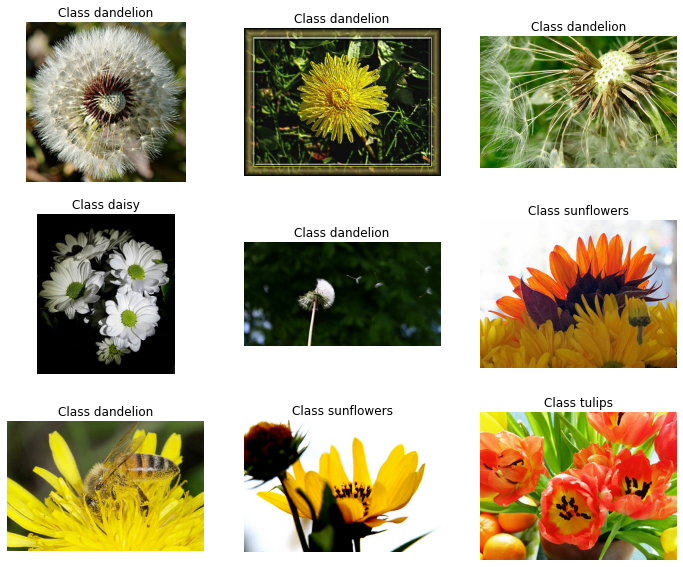

In [8]:
plt.figure(figsize=(12,10))
index = 0
for image, label in train_set_raw.take(9):
  index += 1
  plt.subplot(3, 3, index)
  plt.imshow(image)
  plt.title('Class {}'.format(class_names[label]))
  plt.axis('off')
  
plt.show()

In [9]:
def preprocess(image, label):
  resized_image = tf.image.resize(image, [224, 224])
  final_image = keras.applications.xception.preprocess_input(resized_image)
  return final_image, label

In [14]:
from functools import partial
def central_crop(image):
    shape = tf.shape(image)
    min_dim = tf.reduce_min([shape[0], shape[1]])
    top_crop = (shape[0] - min_dim) // 4
    bottom_crop = shape[0] - top_crop
    left_crop = (shape[1] - min_dim) // 4
    right_crop = shape[1] - left_crop
    return image[top_crop:bottom_crop, left_crop:right_crop]

def random_crop(image):
    shape = tf.shape(image)
    min_dim = tf.reduce_min([shape[0], shape[1]]) * 90 // 100
    return tf.image.random_crop(image, [min_dim, min_dim, 3])

def preprocess(image, label, randomize=False):
    if randomize:
        cropped_image = random_crop(image)
        cropped_image = tf.image.random_flip_left_right(cropped_image)
    else:
        cropped_image = central_crop(image)
    resized_image = tf.image.resize(cropped_image, [224, 224])
    final_image = keras.applications.xception.preprocess_input(resized_image)
    return final_image, label

batch_size = 8
train_set = train_set_raw.shuffle(1000).repeat()
train_set = train_set.map(partial(preprocess, randomize=True)).batch(batch_size).prefetch(1)
valid_set = valid_set_raw.map(preprocess).batch(batch_size).prefetch(1)
test_set = test_set_raw.map(preprocess).batch(batch_size).prefetch(1)

2022-03-23 10:28:56.310175: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


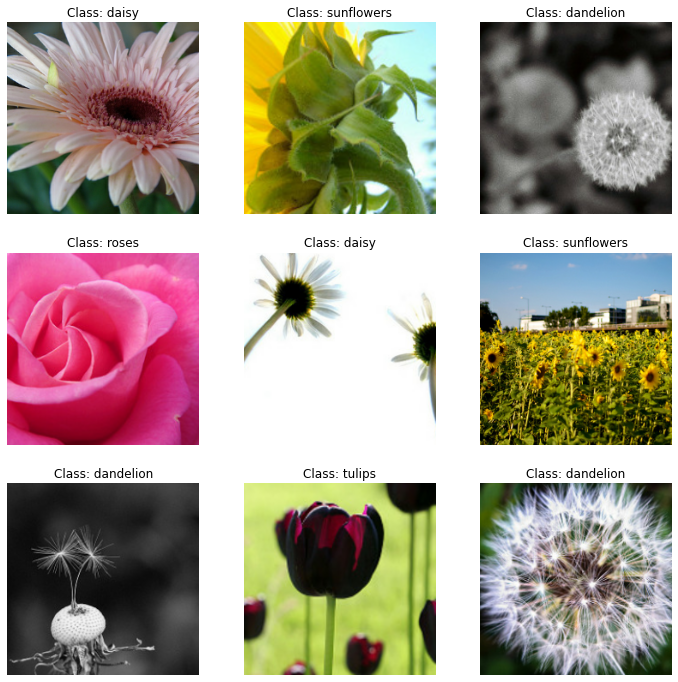

In [11]:
plt.figure(figsize=(12, 12))
for X_batch, y_batch in train_set.take(1):
    for index in range(9):
        plt.subplot(3, 3, index + 1)
        plt.imshow(X_batch[index] / 2 + 0.5)
        plt.title("Class: {}".format(class_names[y_batch[index]]))
        plt.axis("off")

plt.show()

In [12]:
base_model = keras.applications.xception.Xception(weights='imagenet', include_top=False)

avg = keras.layers.GlobalAveragePooling2D()(base_model.output)
output = keras.layers.Dense(n_classes, activation='softmax')(avg)
model = keras.models.Model(inputs=base_model.input, outputs=output)

In [13]:
for layer in base_model.layers:
  layer.trainable = False
  
optimizer = keras.optimizers.SGD(learning_rate=0.2, momentum=0.9, decay=0.01)
model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
history = model.fit(train_set,
                    steps_per_epoch=int(0.75 * dataset_size / batch_size),
                    validation_data=valid_set,
                    validation_steps=int(0.15 * dataset_size / batch_size),
                    epochs=5)

Epoch 1/5


2022-03-23 10:26:57.564106: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8302
2022-03-23 10:26:58.431968: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.30GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2022-03-23 10:26:58.432014: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.30GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2022-03-23 10:26:58.551991: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.21GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory

  1/172 [..............................] - ETA: 13:35 - loss: 1.8916 - accuracy: 0.1250

2022-03-23 10:26:58.826668: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.64GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2022-03-23 10:26:58.826706: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.64GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2022-03-23 10:26:58.859237: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.43GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2022-03-23 10:26:58.859274: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Alloc

111/172 [==================>...........] - ETA: 5s - loss: 2.3108 - accuracy: 0.7815

KeyboardInterrupt: 

In [ ]:
import os
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
os.environ['TF_GPU_ALLOCATOR'] = 'cuda_malloc_async'

In [15]:
for layer in base_model.layers:
    layer.trainable = True

optimizer = keras.optimizers.SGD(learning_rate=0.01, momentum=0.9,
                                 nesterov=True, decay=0.001)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(train_set,
                    steps_per_epoch=int(0.75 * dataset_size / batch_size),
                    validation_data=valid_set,
                    validation_steps=int(0.15 * dataset_size / batch_size),
                    epochs=40)

Epoch 1/40
344/344 [==============================] - 84s 228ms/step - loss: 0.5084 - accuracy: 0.8252 - val_loss: 0.3287 - val_accuracy: 0.8805
Epoch 2/40
344/344 [==============================] - 79s 229ms/step - loss: 0.2609 - accuracy: 0.9132 - val_loss: 0.2973 - val_accuracy: 0.8842
Epoch 3/40
344/344 [==============================] - 81s 237ms/step - loss: 0.1739 - accuracy: 0.9448 - val_loss: 0.2153 - val_accuracy: 0.9265
Epoch 4/40
344/344 [==============================] - 80s 231ms/step - loss: 0.1161 - accuracy: 0.9615 - val_loss: 0.2164 - val_accuracy: 0.9265
Epoch 5/40
344/344 [==============================] - 79s 229ms/step - loss: 0.0610 - accuracy: 0.9800 - val_loss: 0.2967 - val_accuracy: 0.9191
Epoch 6/40
344/344 [==============================] - 79s 230ms/step - loss: 0.0495 - accuracy: 0.9840 - val_loss: 0.2627 - val_accuracy: 0.9191
Epoch 7/40
344/344 [==============================] - 79s 230ms/step - loss: 0.0570 - accuracy: 0.9855 - val_loss: 0.2113 - val_ac

## Klasifikacija i lokalizacija